# Introdction

The goal of this project is to create a model that will assist doctors with identification of patients infected with pneumonia symptoms either due to covid or non-covid disease.

The choice is between double-binary or 3-class classifier. We have chosen to do double-binary classifiers where the first classifier (henceforth, called `Normal Classifier`) will attempt to classify between `normal` vs `infected (non-covid + covid)` cases and the second classifier (henceforth, called `Covid Classifier`) will attempt to classify between `non-covid` vs `covid` cases.

## Project Structure

The following diagram shows the project structure one should have when attempting to reproduce or run the project:

```
root
|--dataset         # original dataset structure
|    |--test
|    |    |--infected
|    |        |--covid
|    |        |--non-covid
|    |    |--normal
|    |--train 
|    |--val
|
|--models          # contains saved models to load for testing and reproducing result
|    |--binaryModelCovidBest
|    |--binaryModelCovidBestSensitivity
|    |--binaryModelCovidSecondBestSensitivity
|    |--binaryModelNormalBest
|    |--binaryModelNormalBestSensitivity
|    |--trinaryModel
|
|--dataset.py      # contains custom dataset and dataloader functions
|--model.py        # contains all model architecture that we tested; final best result uses resnet18 (the Net class)
|--test.py         # contains loading & testing code to check for metrics like accuracy and sensitivity (recall)
|--train.py        # contains saving, preprocessing & training code including loss function's weight adjustment
|--report.ipynb
|--report.pdf
```

# Dataset & Dataloader

A custom dataset and dataloader has been written in `dataset.py`. The module contains 3 classes:
- `ImageDataset` which inherits from `torch.utils.data.Dataset`
- `BinaryClassDataset` which inherits from `ImageDataset`
- `TrinaryClassDataset` which inherits from `ImageDataset`

The same class is used 3 times to load the `train`, `test` and `validation` sets by passing the appropriate arguments. The following code shows how to load the `train` and `validation` sets for the first classifier that attempts to separate between `normal` and `infected`.

Since the `infected` folder contains 2 dataset `covid` and `non-covid`, we use concatenation to **concatenate the dataset**. As a consequence, one of the `normal` dataset have to be **set to 0, so they're not double counted.**

In [2]:
from dataset import BinaryClassDataset, TrinaryClassDataset
from torch.utils.data import DataLoader, ConcatDataset

trainingBatchSize = 4
img_size = (150, 150)
class_dict = {0: 'normal', 1: 'infected'}

# load TRAIN dataset
groups = ['train']
dataset_numbers = {'train_normal': 0, # 0 so it is not double counted when concatenated
                   'train_infected': 2530,
                   }

dataset_paths = {'train_normal': './dataset/train/normal/',
                 'train_infected': './dataset/train/infected/non-covid',
                 }

trainset1 = BinaryClassDataset('train', img_size, class_dict, groups, dataset_numbers, dataset_paths)

dataset_numbers = {'train_normal': 1341,
                   'train_infected': 1345,
                   }

dataset_paths = {'train_normal': './dataset/train/normal/',
                 'train_infected': './dataset/train/infected/covid',
                 }

trainset2 = BinaryClassDataset('train', img_size, class_dict, groups, dataset_numbers, dataset_paths)

trainsets = ConcatDataset([trainset1, trainset2]) 
trainloader = DataLoader(trainsets, batch_size=trainingBatchSize, shuffle=True)

In [3]:
# load VALIDATION dataset
val_groups = ['val']
val_numbers = {'val_normal': 0, # 0 so it is not double counted when concatenated
               'val_infected': 8,
               }

valset_paths = {'val_normal': './dataset/test/normal',
                'val_infected': './dataset/test/infected/non-covid',
                }

valset1 = BinaryClassDataset('val', img_size, class_dict, val_groups, val_numbers, valset_paths)

val_numbers = {'val_normal': 8,
               'val_infected': 8,
               }

valset_paths = {'val_normal': './dataset/val/normal',
                'val_infected': './dataset/val/infected/covid',
                }

valset2 = BinaryClassDataset('val', img_size, class_dict, val_groups, val_numbers, valset_paths)

valsets = ConcatDataset([valset1, valset2])
validationloader = DataLoader(valsets, batch_size=trainingBatchSize, shuffle=True)

Checking that the dataset and dataloader works as intended:

In [4]:
trainset1.describe()
trainset2.describe()
valset1.describe()
valset2.describe()


		It contains a total of 2530 images of size (150, 150).
		Images have been split in 1 groups: ['train'] sets.
		The images are stored in the following locations, each containing the following images:
		
 - train_normal, in folder ./dataset/train/normal/: 0 images.
 - train_infected, in folder ./dataset/train/infected/non-covid: 2530 images.

		It contains a total of 2686 images of size (150, 150).
		Images have been split in 1 groups: ['train'] sets.
		The images are stored in the following locations, each containing the following images:
		
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected, in folder ./dataset/train/infected/covid: 1345 images.

		It contains a total of 8 images of size (150, 150).
		Images have been split in 1 groups: ['val'] sets.
		The images are stored in the following locations, each containing the following images:
		
 - val_normal, in folder ./dataset/test/normal: 0 images.
 - val_infected, in folder ./dataset/test/infected/no

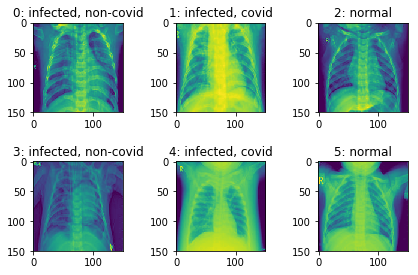

In [5]:
import matplotlib.pyplot as plt

axes = []
def show_tensor_imgs(tensor_imgs, labels):
    '''quick and dirty function to display tensor image'''
    n = len(tensor_imgs)
    fig = plt.figure()
    for i in range(n):
        axes.append(fig.add_subplot(2, 3, i+1)) # add subplot
        subplot_title = (str(i) + ': ' + labels[i])    # name subplot by index
        axes[-1].set_title(subplot_title) 
        plt.imshow(tensor_imgs[i])
    fig.tight_layout()

labels = [
    'infected, non-covid',
    'infected, covid',
    'normal',
    
    'infected, non-covid',
    'infected, covid',
    'normal'
]

imgs = [
    trainset1.open_img('train', 'infected', 1), # infected, non-covid
    trainset2.open_img('train', 'infected', 1), # infected, covid
    trainset2.open_img('train', 'normal', 1),   # normal

    valset1.open_img('val', 'infected', 1), # infected, non-covid
    valset2.open_img('val', 'infected', 1), # infected, covid
    valset2.open_img('val', 'normal', 1)    # normal    
]

show_tensor_imgs(imgs, labels)
plt.show()

# Data Exploration

## Dataset Imbalance

A quick exploration of the dataset shows that there is a clear imbalance:

- 1341 images for the train dataset, normal class,
- 2530 images for the train dataset, infected and non-covid class,
- 1345 images for the train dataset, infected and covid class,
- 234 images for the test dataset, normal class,
- 242 images for the test dataset, infected and non-covid class,
- 138 images for the test dataset, infected and covid class,
- 8 images for the val dataset, normal class,
- 8 images for the val dataset, infected and non-covid class,
- 8 images for the val dataset, infected and covid class.

Plotting the distribtion of cases for `train` dataset and `validation` dataset, we get the following:

Text(0.5, 1.0, 'Dataset Class Distribution')

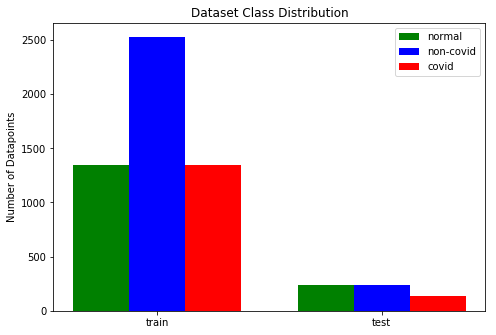

In [6]:
import numpy as np

data = [
    [1341, 234],
    [2530, 242],
    [1345, 138]
]

X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

ax.set_xticks(X + 0.25)
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('Number of Datapoints')
ax.legend(labels=['normal', 'non-covid', 'covid'])
ax.set_title('Dataset Class Distribution')

As can be seen there are twice as many `non-covid` cases as there are `normal` or `covid` cases for the `train` dataset. This is problematic for the second classifier that attempts to separate `covid` cases from `non-covid` as `non-covid` cases are the majority.

Furthermore, in the case of the first classifier that attempts to seperate `normal` cases from `infected` cases, we see even more imbalance where the `infected` class `(covid + non-covid)` becomes an the overwhelming majority in the `train` dataset. 

Text(0.5, 1.0, 'Dataset Class Distribution for First (Normal) Classifier')

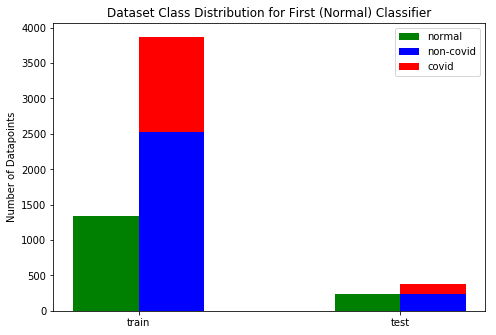

In [13]:
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'g', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[2], color = 'r', width = 0.25, bottom=data[1])

ax.set_xticks(X + 0.125)
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('Number of Datapoints')
ax.legend(labels=['normal', 'non-covid', 'covid'])
ax.set_title('Dataset Class Distribution for First (Normal) Classifier')

Text(0.5, 1.0, 'Dataset Class Distribution for Second (Covid) Classifier')

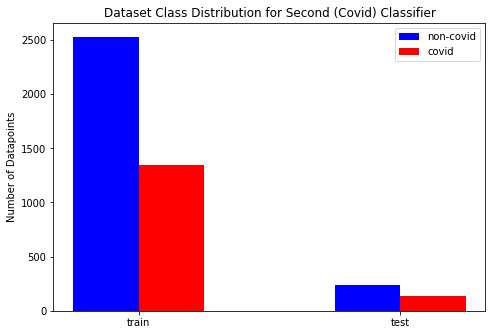

In [15]:
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X, data[1], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[2], color = 'r', width = 0.25)

ax.set_xticks(X + 0.125)
ax.set_xticklabels(['train', 'test'])
ax.set_ylabel('Number of Datapoints')
ax.legend(labels=['non-covid', 'covid'])
ax.set_title('Dataset Class Distribution for Second (Covid) Classifier')

As a result of this imbalance in the dataset for both the first and second classifier, the trained classifier can become 'naive' because it may end up just guessing the majority class while still leading to decent accuracies on test set. 

To remedy this, we have decided to optimize for a different metric called `sensitivity` or `recall` instead of `accuracy`. In healthcare context, where it is far more important to detect the rare minority class, and far more punishing to classify false negative than false positive, metric like `sensitivity` may make more sense than `accuracy`.

## Preprocessing

There are 2 key preprocessing that needs to be done. Normalization and data augmentation.

Normalization is important to centralize the values of the pixels to a certain range. This helps to ensure that the gradient values do not become too small or too large to some feature values, which means one common learning rate can the be used to update the weights across the network.

In [17]:
# getting normalization value
trainset_len = 2530 + 1341 + 1345
train_data = DataLoader(trainsets, batch_size=trainset_len, shuffle=True)
data = next(iter(train_data))
mean = data[0].mean() 
std = data[0].std()

mean, std

(tensor(0.4824), tensor(0.2363))

Another preprocessing that we have done is to add random rotation (max 45 degrees) and random horizontal flip to the image data before it is passed into the network to train.

These data augmentations make sense because the distinguishing feature between `normal` and `infected` cases are the white pneumonia patterns in the x-ray images. These patterns are rotation and translation invariant. Furthermore, it also do not matter whether the pneumonia patterns are found on the right or left lung.

Thus, by adding these random transformations during training, we hope to help the model learn these characteristics.

## Results

1. Accuracy of binary piped and trinary test of optimising accuracy VS optimising sensitivity
2. confusion matrix
3. results on validation set (correct vs wrong classification


reslt (rn test, compare reslt of acc optimized, sensitivty ooptimized, confsion matirri, show img of wrong classification)